# Vortex panel method

The previous notebook introduced the concept of vortex sheets. We will now extend this concept to solve to the flow around general objects.

## General vortex sheets

A curved vortex sheet with a variable strength can describe the flow around any immersed object. This is achieved by having the sheet act as an infinitely thin version of the boundary layer to enforce the no-slip boundary condition. 

---
![Vortex sheets as boundary layers](resources/impulse.png)

---

In other words we use the sheets to force the tangential velocity $u_s$ to zero at every point $s$ on the body surface $\cal S$

$$u_s = \vec u \cdot \hat s = 0 \quad s \in \cal S.$$

From the previous notebook, we know the velocity at any point is determined by an integral over the whole vortex sheet. Therefore, the tangential velocity condition is

$$ u_s = \left[\vec U_\infty+\frac{\partial}{\partial \vec x}\oint_{\cal S} \frac{\gamma(s')}{2\pi}\theta(s,s')\ ds'\right] \cdot\hat s = 0 $$

where $\vec U_\infty$ is the background velocity that has been added by superposition. 

**If we can use this equation to determine the strength distribution $\gamma(s)$ along the sheet then we will have solved for the potential flow around the body!**

## Descrete vortex panels

For general body surface shapes the velocity is a highly nonlinear function of $\gamma(s)$, rendering analytic solution unlikely. We could attempt some complex analytic expansions, but why would we want to do that?

##### Numerical fundamental: Discritization
##### Replace continuous functions with linear approximations

We already know that the velocity depends **linearly** on $\gamma$ for a vortex panel. This makes it easy to solve for $\gamma$ as a function of $u_s$. And we can add any number of panels together using superposition.

Therefore, if we break up the continuous sheet into a series of vortex panels, we can approximate the tangential velocity condition above, and use it to solve for $\gamma$. 

---
![Vortex panelized](resources/graphics2.png)

---

This is the essense of the *vortex panel method*.

## Linear velocity function

First, lets write the velocity induced by a single panel in a way that makes the linearity explicit:

$$ \vec u(x,y)=\gamma\ \vec f(x,y \ |\ x_0,y_0,x_1,y_1)$$

where $\vec f$ is a function that depends on the panel geometry. 

In fact, we've already written all the code we need to evaluate this function in the last notebook...

##### Quiz 1:

Which python function from the previous notebook can we use as $\vec f$?

1. `get_u, get_v`
2. `Panel.velocity` if we set $\gamma=1$ for the panel.
3. `Panel.velocity` if we set $\gamma=0$ for the panel.

---
Lets copy that old code here:

In [22]:
import numpy

# velocity component functions
def get_u( x, y, S, gamma ):
    return gamma/(2*numpy.pi)*(numpy.arctan((x-S)/y)-numpy.arctan((x+S)/y))
def get_v( x, y, S, gamma ):
    return gamma/(4*numpy.pi)*(numpy.log(((x+S)**2+y**2)/((x-S)**2+y**2)))

In [23]:
# vortex panel class
class Panel:
    
    # save the inputs and pre-compute factors for the coordinate tranform
    def __init__( self, x0, y0, x1, y1, gamma=0 ):
        self.x,self.y,self.gamma = [x0,x1],[y0,y1],gamma
        self.xc = 0.5*(x0+x1)                # panel x-center
        self.yc = 0.5*(y0+y1)                # panel y-center
        self.S = numpy.sqrt(                 # ...
                            (x1-self.xc)**2+(y1-self.yc)**2) # panel width
        self.sx = (x1-self.xc)/self.S        # unit vector in x
        self.sy = (y1-self.yc)/self.S        # unit vector in y
    
    # get the velocity!
    def velocity( self, x, y, gamma=None ):
        if gamma is None: gamma = self.gamma # default gamma
        xp,yp = self.transform_xy( x, y )    # transform
        up = get_u( xp, yp, self.S, gamma )  # get u prime
        vp = get_v( xp, yp, self.S, gamma )  # get v prime
        return self.rotate_uv( up, vp )      # rotate back
    
    # plot the panel
    def plot(self):
        return pyplot.plot(self.x,self.y,'k-',lw=2)
    
    # transform from global to panel coordinates
    def transform_xy( self, x, y ):
        xt = x-self.xc               # shift x
        yt = y-self.yc               # shift y
        xp = xt*self.sx+yt*self.sy   # rotate x
        yp = yt*self.sx-xt*self.sy   # rotate y
        return [ xp, yp ]
    
    # rotate velocity back to global coordinates
    def rotate_uv( self, up, vp):
        u = up*self.sx-vp*self.sy    # reverse rotate u prime
        v = vp*self.sx+up*self.sy    # reverse rotate v prime
        return [ u, v ]

We added an [optional argument](http://www.deadlybloodyserious.com/2008/05/default-argument-blunders/) to `Panel.velocity` to set `gamma`. If we don't specify `gamma` the function will use `self.gamma` giving us the same output as in the previous note book.

## Array of panels

The next step is to extend this to more than one panel and to add the background flow.

To help make this more concrete, lets consider a polynomial-shape body. I found this beautiful little equation to define [regular polynomials](http://math.stackexchange.com/questions/41940/is-there-an-equation-to-describe-regular-polygons/41954#41954).

In [24]:
def polynomial(theta,n):
    a = theta % (2.*numpy.pi/n)-numpy.pi/n
    r = numpy.cos(numpy.pi/n)/numpy.cos(a)
    return [r*numpy.cos(theta),r*numpy.sin(theta)]

where $n$ is the number of sides in the polynomial, and `theta`=$\theta$ is the polar angle around the origin.

In the case of a triangle it only takes three panels to define the shape:

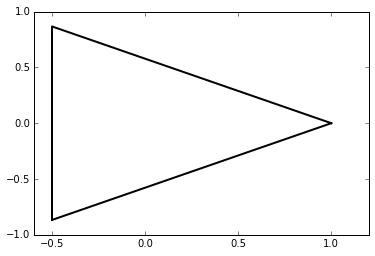

In [25]:
N_panels = 3                                   # number of panels
triangle = numpy.empty(N_panels, dtype=object)   # initialize an array of panels

# Define the end-points of the panels
theta_ends = numpy.linspace(0, -2*numpy.pi, N_panels+1)
x_ends,y_ends = polynomial( theta_ends, n=3)

# Initialize each panel with the end points
for i in xrange(N_panels):
    triangle[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

# Plot it
from matplotlib import pyplot
%matplotlib inline
for p in triangle: p.plot()

Looks good. Note the code 

`for p in triangle:` 

loops through all the panels in the array. Very handy and clean.

---
So, what is the velocity induced by these panels? 

Using superposition, the total velocity at any point $x,y$ is simply

$$ \vec u(x,y) = \vec U_\infty+\sum_{j=0}^{N-1} \gamma_j \ \vec f_j(x,y) $$

where we use the index $j$ to label each of the $N$ panels.

This can be coded as:

In [26]:
def flow_velocity(panels,x,y,alpha=0):
    # get the uniform velocity ( make it the same size & shape as x )
    u = numpy.cos(alpha)*numpy.ones_like(x)
    v = numpy.sin(alpha)*numpy.ones_like(x)
    
    # add the velocity contribution from each panel
    for p in panels:
        u0,v0 = p.velocity(x,y)
        u = u+u0
        v = v+v0
    
    return [u,v]

where the `alpha` argument defines the angle of attack. To visualize this, we copy the grid definition and plotting code from before to define a new function `plotFlow`:

In [27]:
def plot_flow(panels,alpha=0,xmax=2,N_grid=100):    # define the grid
    X = numpy.linspace(-xmax, xmax, N_grid)     # computes a 1D-array for x
    Y = numpy.linspace(-xmax, xmax, N_grid)     # computes a 1D-array for y
    x, y = numpy.meshgrid(X, Y)                 # generates a mesh grid
    
    # get the velocity from the free stream and panels
    u,v = flow_velocity(panels,x,y,alpha)
    
    # plot it
    pyplot.figure(figsize=(8,11))               # set size
    pyplot.xlabel('x', fontsize=16)             # label x
    pyplot.ylabel('y', fontsize=16)             # label y
    m = numpy.sqrt(u**2+v**2)                   # compute velocity magnitude
    velocity = pyplot.contourf(x, y, m)         # plot magnitude contours
    cbar = pyplot.colorbar(velocity, orientation='horizontal')
    cbar.set_label('Velocity magnitude', fontsize=16);
    pyplot.quiver(x[::4,::4], y[::4,::4],
                  u[::4,::4], v[::4,::4])       # plot vector field
#   pyplot.streamplot(x, y, u, v)               # plots streamlines - this is slow!
    for p in panels: p.plot()

Are we done? Let's plot the flow and check...

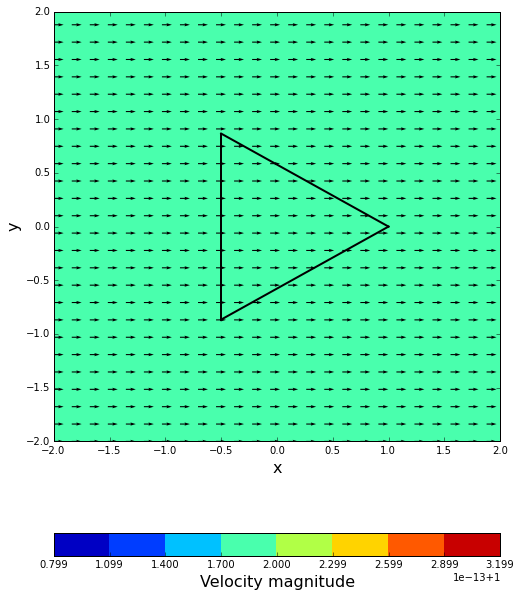

In [28]:
plot_flow(triangle)

##### Quiz 2

Why is the flow going through the body above?

1. We set `gamma=0` for the panels
1. We haven't applied the no-slip condition
1. We haven't determined the correct `gamma` for each panel

## System of linear equations

The no-slip boundary condition is

$$ u_s = \hat s\cdot\left[\vec U_\infty + \sum_{j=0}^{N-1} \gamma_j \ \vec f_j(x,y)\right]=0 $$

We note again that this system is **linear** in $\gamma$. 

So the goal is to set $\gamma$ on each sheet such that this condition is enforced on the body.

##### Quiz 3

How many unknowns are there?

1. $1$
1. $N$
1. $N^2$

But we only have one equation, the no-slip condition... right?

##### Numerical fundamental: Consistency
##### Develop enough equations to match the unknowns

For a linear system of equations to be consistent, that is for it to have a solution, we need as many equations as unknowns. 

Luckily the no-slip condition is a continuous equation - it applies to *every* point on the body. **Therefore, we can evaluate the boundary equation multiple times - say at the center of each panel**. Then we will have a consistent linear system.

---

There is one important point to consider before we do this.

The tangential velocity is discontinuous across the vortex panel (the jump from no-slip to the free stream) so we need to be careful to apply the no-slip condition on the *body* side of the panel. The way we've drawn it, this is the *negative* side ($y^-$) in the coordinates of each panel.

##### Quiz 4

What tangential velocity does a panel induce on the negative side of itself?

1. $u_s =  \frac 12 \gamma$
1. $u_s = -\frac 12 \gamma$
1. $u_s = U_\infty$

(Hint: think about the previous notebook.)

Using this relation, the tangential velocity at the center of each panel is

$$ \frac 12 \gamma_i + \hat s_i \cdot \left[ \vec U_\infty + \sum_{j=0, j\ne i}^N \gamma_j \ \vec f_j(x_i,y_i)\right] = 0 \quad i=0\ldots N-1$$

where $\hat s_i$ is the tangent vector of panel $i$, and $x_i,y_i$ is the center of that panel. 

Notice that the equation for the velocity on panel $i$ depends on the strength of every other panel. Will we need to write a special function to solve for $\gamma$?

##### Numerical fundamental: Linear Algebra Packages
##### Never write your own matrix solver

Every worthwhile numerical language has a set of linear algebra solution routines - in numpy it is the [`linalg` package](http://docs.scipy.org/doc/numpy/reference/routines.linalg.html). All we need to do is reform this system to look like

$$ \mathbf{A \gamma = b} $$

and use the function `numpy.linalg.solve`. From the equation above, we see

$$ a_{ij} = \vec f_j(x_i,y_i) \cdot \hat s_i \quad i\ne j$$

$$ a_{ii} = \frac 1 2, \quad b_i = -\vec U \cdot \hat s_i$$

where $a_{ij}$ are the coefficient of the matrix $\mathbf A$ which represent the *influence* of panel $j$ on panel $i$, and $b_i$ are the coefficients of the vector $\mathbf b$ which represent the forcing of the external flow on panel $i$.

## Construct and solve

Again - all we need to do is construct (or *assemble*) this matrix and vector, and use the function to solve for $\gamma_i$. 

First, we write a function for the cross-influence term:

In [29]:
# define the influence of panel_j on panel_i
def influence(panel_i,panel_j):
    u,v = panel_j.velocity(panel_i.xc,panel_i.yc,gamma=1)
    return u*panel_i.sx+v*panel_i.sy

which uses the optional `gamma=1` argument to evaluate $\vec f_j$. 

Next, we write a function to fill the matrix $\mathbf A$ using the [`enumerate`](https://azitech.wordpress.com/2011/07/06/pythons-enumerate-function/) function, and the RHS vector $\mathbf b$ using a [list comprehension](http://www.pythonforbeginners.com/lists/list-comprehensions-in-python/) (which is terribly named, but very handy).

In [30]:
# construct the linear system
def construct_A_b(panels,alpha=0):
    # construct matrix
    N_panels = len(panels)
    A = numpy.empty((N_panels, N_panels), dtype=float) # empty matrix
    numpy.fill_diagonal(A, 0.5)                        # fill diagonal with 1/2
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:                                 # off-diagonals
                A[i,j] = influence(p_i,p_j)            # find influence
    
    # computes the RHS
    b = [-numpy.cos(alpha)*p.sx-numpy.sin(alpha)*p.sy for p in panels]
    return [A,b]

Finally, we can write a function to solve for $\gamma_i$

In [31]:
# determine the vortex strength on a set of panels
def solve_gamma(panels,alpha=0):
    A,b = construct_A_b(panels,alpha)  # construct linear system
    gamma = numpy.linalg.solve(A, b)   # solve for gamma!
    for i,p_i in enumerate(panels):
        p_i.gamma = gamma[i]           # update panels

Lets test it out!

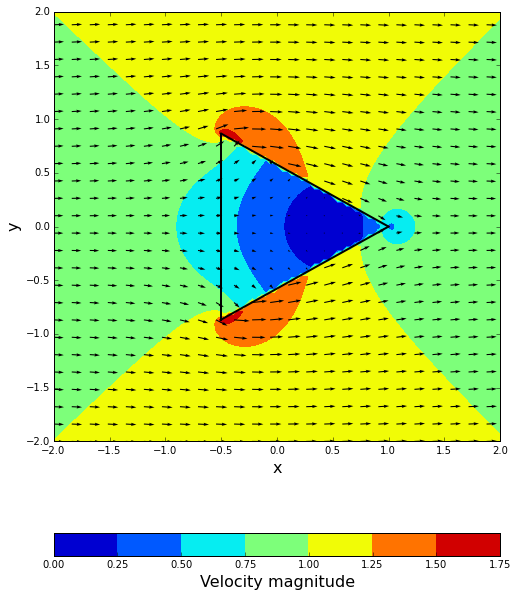

In [32]:
solve_gamma(triangle)  # solve for gamma
plot_flow(triangle)    # compute flow field and plot

Much better, but...

##### Quiz 5

Why is there still flow through the wedge?

1. Modeling error       (ie incorrect conditions)
1. Numerical error      (ie insufficient resolution)
1. Implementation error (ie inadequate care)

(Hint: one of these is immediately testable.)

##### Numerical Fundamental: Convergence with resolution
##### The more panels you use, the closer you should get to the analytic solution

## Other objects

We can now get the flow around **any** shape! Let try one we know well - a circle:

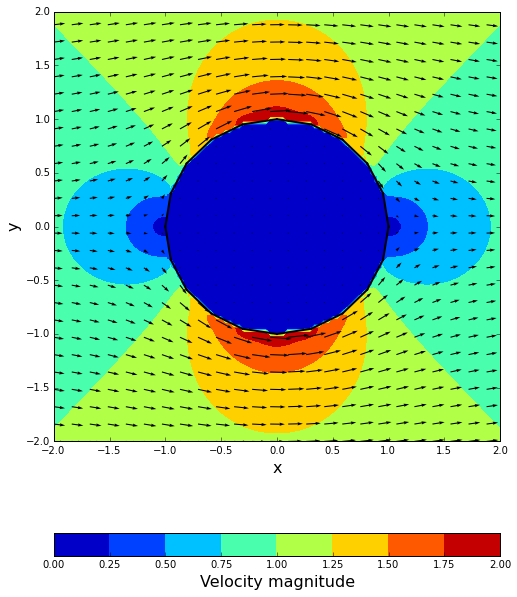

In [33]:
# defining the end-points of the panels
N_panels = 20
x_ends = numpy.cos(numpy.linspace(0, -2*numpy.pi, N_panels+1))
y_ends = numpy.sin(numpy.linspace(0, -2*numpy.pi, N_panels+1))

# defining the panels
circle = numpy.empty(N_panels, dtype=object)
for i in xrange(N_panels):
    circle[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

solve_gamma(circle)  # solve for gamma
plot_flow(circle)    # compute flow field and plot

Looks about right!

##### Quiz 6

This vortex panel method can be used to solve for the flow around:

1. multiple bodies
1. three-dimensional bodies
1. a sailboat keel

---
##### Your turn

Write a method to acheive this. It should only take a few lines of code.

Hint: numpy.concatenate((body_1,body_2))

In [34]:
# your code here

---
Ignore the line below - it just loads the style sheet.

In [35]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()